We import the data and the needed libraries:

In [28]:
%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

C, Ceq = np.loadtxt("true_dat.txt", unpack = True, usecols = (0, 1)) 

We create another set of data (called "offset_dat.txt") by adding gaussian noise to the previous data, in order to roughly simulate the experimental error affecting the real measurements:


In [29]:
Ctilde = [i + np.random.normal(0, 0.5e-12) for i in C] 
Ceqtilde = [i + np.random.normal(0, 0.5e-12) for i in Ceq] 

data = np.column_stack([Ctilde, Ceqtilde]) 
np.savetxt("offset_dat.txt", data, delimiter = "\t") 

We prepare the fit of the data with gaussian noise  previously generated:

In [30]:
from scipy.optimize import curve_fit   #We use this library to perform the fit

def fitfunc(x, a, b):                  #This is the model to be fit
    return 1./(1./(x + a) + b) 

fit_pars, cov_matrix = curve_fit(fitfunc, Ctilde, Ceqtilde, p0 = [10**(-11), 5*(10**(10))])   #We give the expected values to the model 
print(fit_pars)                                                                               #in order to speed up the algorithm's convergence

[9.95814363e-12 4.99663533e+10]


Now we plot the results:

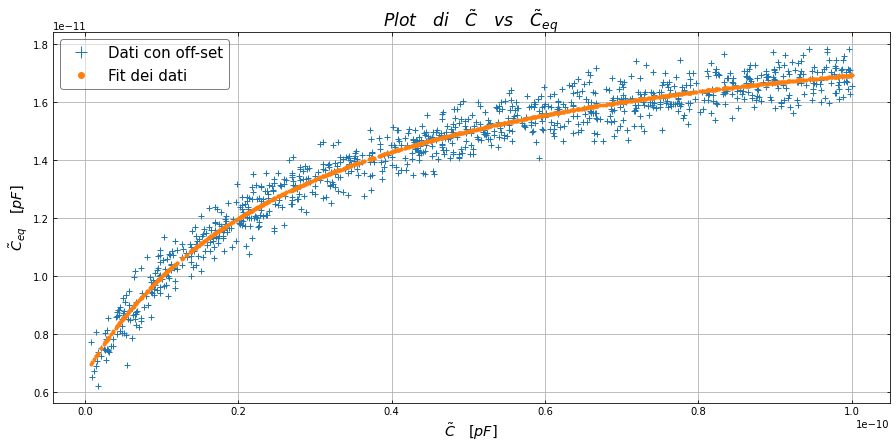

In [31]:
fig = plt.figure(figsize = (15, 15))    
ax1 = fig.add_subplot(211)
ax1.grid()
ax1.set_xlabel(r"$\tilde{C} \quad [pF]$", fontsize = 'x-large')
ax1.set_ylabel(r"$\tilde{C}_{eq} \quad [pF]$", fontsize = 'x-large')
ax1.set_title(r"$Plot \quad  di \quad \tilde{C} \quad vs \quad \tilde{C}_{eq}$", fontsize = 'xx-large')
ax1.tick_params(direction = 'in', bottom = 'True', top = 'True', right = 'True', left = 'True')
ax1.plot(Ctilde, Ceqtilde, "+", linestyle = 'None', label = 'Dati con off-set')
ax1.plot(Ctilde, fitfunc(Ctilde, *fit_pars), '.', linestyle = 'None', label = 'Fit dei dati')
ax1.legend(prop = {'size': 15}, markerscale = 2, framealpha = 0.5, edgecolor = 'black')
plt.show()

Here we artificially create some gaussian errors that have to be associated to the Ceq values:

In [32]:
ErrCeq = np.array([np.random.normal(0, 3e-12) for i in Ceq])
CEQ = [i*(10**2) for i in Ceq]
data1 = np.column_stack([CEQ, ErrCeq])  
np.savetxt("errorbar_dat.txt", data1, delimiter = "\t") 

DeltaCeq = np.array(CEQ) + ErrCeq

Finally we apply the MonteCarlo - Markov Chain method (MCMC) to give a better estimate of the previously performed fit:

In [33]:
#Punto 4.
!pip install emcee
import emcee

A_ = 10**(-11)
B_ = 5*(10**(10))

def log_likelihood(theta, C, Ceq, ErrCeq):
    A, B = theta
    model = 1./(1./(C + A) + B) 
    sigma = ErrCeq**2 
    return -0.5*np.sum((Ceq - model)**2/sigma + np.log(sigma))

def log_prior(theta):
    A, B = theta
    if 0.5*(10**(-11)) < A < 9*(10**(-11)) and 1*(10**(10)) < B < 9*(10**(10)):
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


nwalkers = 32   #Number of random walkers
ndim = 2        #The dimensionality of the parameter space (A, B)
nmcmc = 5000    #The MCMC steps

#Initial position
pos = A_ + 1e-15 * np.random.randn(nwalkers)
pos1 = B_ + 1e6 * np.random.randn(nwalkers)

P = np.array([pos, pos1]).transpose()

#Running the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(C, Ceq, ErrCeq))
sampler.run_mcmc(P, nmcmc, progress=True);    # The ; avoids some prints to the screen


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


100%|██████████| 5000/5000 [00:12<00:00, 388.11it/s]


Let's print the results:

Text(0.5, 0, 'MCMC step')

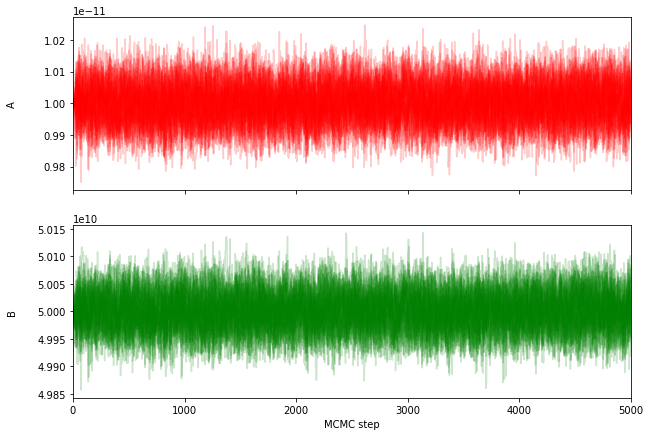

In [34]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A", "B"]
col = ['r', 'g', 'b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], col[i], alpha=0.2)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("MCMC step")